In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

# for now this is defined here bc we use it to set up constants
def get_subpaths(path, length):
    ''' Given a path, return a set of all sub-paths of the specified length. '''
    return {tuple(path[i:i + length]) for i in range(len(path) - length + 1)}


################################# Set up all of our constants #################################

# Barriers can exist in any open hex, excluding the hexes right next to the reward ports
POSSIBLE_BARRIERS = np.arange(5, 48)
POSSIBLE_BARRIERS = POSSIBLE_BARRIERS[~np.isin(POSSIBLE_BARRIERS, [5, 6, 33, 38, 43, 47])]

# Minimum distance from port to critical choice point = 6 (including port hex)
ILLEGAL_CHOICE_POINTS_6 = [4, 6, 5, 11, 8, 10, 7, 9, 49, 38, 47, 32, 42, 27, 37, 46, 48, 43, 33, 39, 28, 44, 34, 23]

# Max straight path length to reward port = 6 hexes. (illegal paths are 7+)
MAX_STRAIGHT_PATH_TO_PORT = 6
STRAIGHT_PATHS_TO_PORTS = [[1, 4, 6, 8, 11, 14, 18, 22, 27, 32, 38, 49, 2], 
                  [1, 4, 5, 7, 9, 12, 15, 19, 23, 28, 33, 48, 3],
                  [2, 49, 47, 42, 46, 41, 45, 40, 44, 39, 43, 48, 3]]
# Max straight path length inside maze = 6 hexes. (illegal paths are 7+)
MAX_STRAIGHT_PATH_INSIDE_MAZE = 6
STRAIGHT_PATHS_INSIDE_MAZE = [[5, 7, 10, 13, 17, 21, 26, 31, 37, 42, 47],
                              [9, 12, 16, 20, 25, 30, 36, 41, 46],
                              [6, 8, 10, 13, 16, 20, 24, 29, 34, 39, 43],
                              [11, 14, 17, 21, 25, 30, 35, 40, 44],
                              [38, 32, 37, 31, 36, 30, 35, 29, 34, 28, 33],
                              [27, 22, 26, 21, 25, 20, 24, 19, 23]]

# Get all illegal straight paths to ports
illegal_straight_paths_list = []
for path in STRAIGHT_PATHS_TO_PORTS:
    for sub_path in get_subpaths(path, MAX_STRAIGHT_PATH_TO_PORT+1):
        illegal_straight_paths_list.append(sub_path)

# Store illegal straight paths as a set of tuples for O(1) lookup time
ILLEGAL_STRAIGHT_PATHS_TO_PORT = {tuple(path) for path in illegal_straight_paths_list}

# Get all illegal straight paths inside the maze
illegal_straight_paths_list = []
for path in STRAIGHT_PATHS_INSIDE_MAZE:
    for sub_path in get_subpaths(path, MAX_STRAIGHT_PATH_INSIDE_MAZE+1):
        illegal_straight_paths_list.append(sub_path)

# Store illegal straight paths as a set of tuples for O(1) lookup time
ILLEGAL_STRAIGHT_PATHS_INSIDE_MAZE = {tuple(path) for path in illegal_straight_paths_list}

################################# Define a bunch of functions #################################

def create_hex_maze():
    '''
    Use networkx to create a graph representing the empty hex maze before any barriers are added.
    
    Returns: a new networkx graph representing all of the hexes in the hex maze
    ''' 
    empty_hex_maze = nx.Graph()
    
    # Define all nodes and edges to create the empty maze
    add_edges_to_node(empty_hex_maze, 1, [4])
    add_edges_to_node(empty_hex_maze, 4, [1, 5, 6])
    add_edges_to_node(empty_hex_maze, 6, [4, 8])
    add_edges_to_node(empty_hex_maze, 5, [4, 7])
    add_edges_to_node(empty_hex_maze, 8, [6, 11, 10])
    add_edges_to_node(empty_hex_maze, 7, [5, 10, 9])
    add_edges_to_node(empty_hex_maze, 11, [8, 14])
    add_edges_to_node(empty_hex_maze, 10, [8, 7, 13])
    add_edges_to_node(empty_hex_maze, 9, [7, 12])
    add_edges_to_node(empty_hex_maze, 14, [11, 18, 17])
    add_edges_to_node(empty_hex_maze, 13, [10, 17, 16])
    add_edges_to_node(empty_hex_maze, 12, [9, 16, 15])
    add_edges_to_node(empty_hex_maze, 18, [14, 22])
    add_edges_to_node(empty_hex_maze, 17, [14, 13, 21])
    add_edges_to_node(empty_hex_maze, 16, [13, 12, 20])
    add_edges_to_node(empty_hex_maze, 15, [12, 19])
    add_edges_to_node(empty_hex_maze, 22, [18, 27, 26])
    add_edges_to_node(empty_hex_maze, 21, [17, 26, 25])
    add_edges_to_node(empty_hex_maze, 20, [16, 25, 24])
    add_edges_to_node(empty_hex_maze, 19, [15, 24, 23])
    add_edges_to_node(empty_hex_maze, 27, [22, 32])
    add_edges_to_node(empty_hex_maze, 26, [22, 21, 31])
    add_edges_to_node(empty_hex_maze, 25, [21, 20, 30])
    add_edges_to_node(empty_hex_maze, 24, [20, 19, 29])
    add_edges_to_node(empty_hex_maze, 23, [19, 28])
    add_edges_to_node(empty_hex_maze, 32, [27, 38, 37])
    add_edges_to_node(empty_hex_maze, 31, [26, 37, 36])
    add_edges_to_node(empty_hex_maze, 30, [25, 36, 35])
    add_edges_to_node(empty_hex_maze, 29, [24, 35, 34])
    add_edges_to_node(empty_hex_maze, 28, [23, 34, 33])
    add_edges_to_node(empty_hex_maze, 38, [32, 49])
    add_edges_to_node(empty_hex_maze, 37, [31, 32, 42])
    add_edges_to_node(empty_hex_maze, 36, [30, 31, 41])
    add_edges_to_node(empty_hex_maze, 35, [29, 30, 40])
    add_edges_to_node(empty_hex_maze, 34, [28, 29, 39])
    add_edges_to_node(empty_hex_maze, 33, [28, 48])
    add_edges_to_node(empty_hex_maze, 49, [2, 38, 47])
    add_edges_to_node(empty_hex_maze, 42, [37, 46, 47])
    add_edges_to_node(empty_hex_maze, 41, [36, 45, 46])
    add_edges_to_node(empty_hex_maze, 40, [35, 44, 45])
    add_edges_to_node(empty_hex_maze, 39, [34, 43, 44])
    add_edges_to_node(empty_hex_maze, 48, [3, 33, 43])
    add_edges_to_node(empty_hex_maze, 2, [49])
    add_edges_to_node(empty_hex_maze, 47, [49, 42])
    add_edges_to_node(empty_hex_maze, 46, [42, 41])
    add_edges_to_node(empty_hex_maze, 45, [41, 40])
    add_edges_to_node(empty_hex_maze, 44, [40, 39])
    add_edges_to_node(empty_hex_maze, 43, [39, 48])
    add_edges_to_node(empty_hex_maze, 3, [48])
    return empty_hex_maze
    

def add_edges_to_node(graph, node, edges):
    '''
    Add all edges to the specified node in the graph. 
    If the node does not yet exist in the graph, add the node.
    '''
    for edge in edges:
        graph.add_edge(node, edge)
        
def find_all_critical_choice_points(graph):
    '''
    Given a graph representing the hex maze, 
    find all critical choice points between reward ports 1, 2, and 3.
    
    Returns: a set of all critical choice points
    '''
    paths12 = list(nx.all_shortest_paths(graph, source=1, target=2))
    paths13 = list(nx.all_shortest_paths(graph, source=1, target=3))
    paths23 = list(nx.all_shortest_paths(graph, source=2, target=3))
    
    choice_points = set()
    # all choice points from port 1
    for path_a in paths12:
        for path_b in paths13:
            shared_path = [hex for hex in path_a if hex in path_b]
            choice_points.add(shared_path[-1])
    
    # all choice points from port 2
    for path_a in paths12:
        for path_b in paths23:
            shared_path = [hex for hex in path_a[::-1] if hex in path_b]
            choice_points.add(shared_path[-1])
            
    # all choice points from port 3
    for path_a in paths13:
        for path_b in paths23:
            shared_path = [hex for hex in path_a[::-1] if hex in path_b[::-1]]
            choice_points.add(shared_path[-1])
    return choice_points


def has_illegal_straight_path(graph):
    '''
    Given a graph of the hex maze, checks if there are any illegal straight paths.
    Returns: the (first) offending path, or False if none
    '''
    optimal_paths = []
    optimal_paths.extend(list(nx.all_shortest_paths(graph, source=1, target=2)))
    optimal_paths.extend(list(nx.all_shortest_paths(graph, source=1, target=3)))
    optimal_paths.extend(list(nx.all_shortest_paths(graph, source=2, target=3)))

    # We do 2 separate checks here beacause we may have different path length critera
    # for paths to reward ports vs inside the maze
    
    # First check all subpaths against illegal paths to a reward port
    subpaths1 = set()
    for path in optimal_paths:
        subpaths1.update(get_subpaths(path, MAX_STRAIGHT_PATH_TO_PORT+1))

    for path in subpaths1:
        if path in ILLEGAL_STRAIGHT_PATHS_TO_PORT:
            return path # (equivalent to returning True)
        
    # Now check all subpaths against illegal paths inside the maze
    subpaths2 = set()
    for path in optimal_paths:
        subpaths2.update(get_subpaths(path, MAX_STRAIGHT_PATH_INSIDE_MAZE+1))

    for path in subpaths2:
        if path in ILLEGAL_STRAIGHT_PATHS_INSIDE_MAZE:
            return path # (equivalent to returning True)
    
    # If we did all of those checks and found no straight paths, we're good to go!
    return False


def is_valid_maze(graph, complain=False):
    '''
    Given a graph representing a possible hex maze configuration, check if it is valid 
    using the following criteria: 
    - there are no unreachable hexes (includes that all reward ports are reachable)
    - path lengths between reward ports are between 15-25 hexes
    - all critical choice points are >=6 hexes away from a reward port
    - there are a maximum of 3 critical choice points
    - no straight paths >MAX_STRAIGHT_PATH_TO_PORT hexes to reward port (including port hex)
    - no straight paths >STRAIGHT_PATHS_INSIDE_MAZE in middle of maze
    
    Optional argument complain (defaults to False):
    - When True: If our maze configuration is invalid, print out the reason why.
    
    Returns: True if the hex maze is valid, False otherwise
    '''

    # Make sure all (non-barrier) hexes are reachable
    if not nx.is_connected(graph):
        if complain:
            print("BAD MAZE: At least one (non-barrier) hex is unreachable")
        return False
    
    # Make sure path lengths are between 15-25
    len12 = nx.shortest_path_length(graph, source=1, target=2)
    len13 = nx.shortest_path_length(graph, source=1, target=3)
    len23 = nx.shortest_path_length(graph, source=2, target=3)
    reward_port_lengths = [len12, len13, len23]
    if min(reward_port_lengths) <= 13:
        if complain:
            print("BAD MAZE: Path between reward ports is too short (<=13)")
        return False
    if max(reward_port_lengths) - min(reward_port_lengths) < 4:
        if complain:
            print("BAD MAZE: Distance difference in reward port paths is too small (<4)")
        return False
    if max(reward_port_lengths) > 25:
        if complain:
            print("BAD MAZE: Path between reward ports is too long (>25)")
        return False

    # Make sure all critical choice points are >=6 hexes away from a reward port
    choice_points = find_all_critical_choice_points(graph)
    if any(hex in ILLEGAL_CHOICE_POINTS_6 for hex in choice_points):
        if complain:
            print("BAD MAZE: Choice point <6 hexes away from reward port")
        return False
    
    # Make sure there are not more than 3 critical choice points
    if len(choice_points) > 3:
        if complain:
            print("BAD MAZE: More than 3 critical choice points")
        return False
    
    # Make sure there are no straight paths
    illegal_path = has_illegal_straight_path(graph)
    if illegal_path:
        if complain:
            print("BAD MAZE: Straight path ", illegal_path)
        return False
    
    return True

Use a naive generation approach to generate an allowable hex maze configuration (randomly generate possible mazes until we get a good one)

BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: Path between reward ports is too short (<=13)
BAD MAZE: Distance difference in reward port paths is too small (<4)
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: Distance difference in reward port paths is too small (<4)
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one

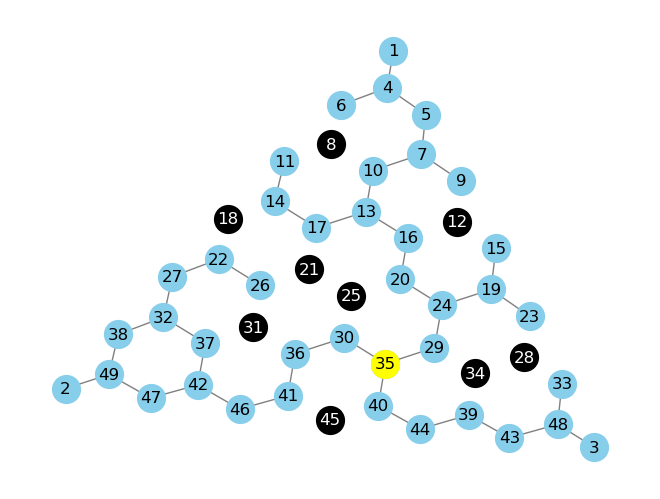

In [49]:
# Create the empty hex maze
empty_hex_maze = create_hex_maze()
barriers = []

# Generate a set of 9 random barriers until we get a good maze
is_good_maze = False
while not is_good_maze:
    # Start with an empty hex maze (no barriers)
    G = empty_hex_maze.copy()

    # Randomly select 9 barriers
    barriers = np.random.choice(POSSIBLE_BARRIERS, size=9, replace=False)
    
    # Add the barriers to the empty maze
    for barrier in barriers:
        G.remove_node(barrier)
        
    # Check if this is a good maze
    is_good_maze = is_valid_maze(G, complain=True)

# Print the barriers we chose
print("Barriers:", barriers)
# Once we get a good maze, print some stats about it
print("Shortest path between 1 and 2:", nx.shortest_path(G, source=1, target=2))
print("Length of path:", len(nx.shortest_path(G, source=1, target=2)))
print("Shortest path between 1 and 3:", nx.shortest_path(G, source=1, target=3))
print("Length of path:", len(nx.shortest_path(G, source=1, target=3)))
print("Shortest path between 2 and 3:", nx.shortest_path(G, source=2, target=3))
print("Length of path:", len(nx.shortest_path(G, source=2, target=3)))

print("Critical choice point(s):")
choice_points = find_all_critical_choice_points(G)
print(choice_points)

# Get the graph layout of the original maze
pos = nx.kamada_kawai_layout(empty_hex_maze)

# Draw the available hexes using this layout
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=400)

# Add the barriers in black
nx.draw_networkx_nodes(empty_hex_maze, pos, nodelist={b: b for b in barriers}, node_color='black', node_size=400)   
nx.draw_networkx_labels(empty_hex_maze, pos, labels={b: b for b in barriers}, font_color='white')

# Make the choice point(s) yellow
for choice_point in choice_points:
    nx.draw_networkx_nodes(empty_hex_maze, pos, nodelist=[choice_point], node_color='yellow', node_size=400)
        
plt.show()

In [ ]:
from tqdm import tqdm

def generate_good_maze():
    '''
    Keep generating hex mazes until we get a good one! 

    Returns: the set of barriers for the good hex maze
    '''
    # Create the empty hex maze
    start_maze = create_hex_maze()
    barriers = set()

    # Generate a set of 9 random barriers until we get a good maze
    is_good_maze = False
    while not is_good_maze:
        # Start with an empty hex maze (no barriers)
        test_maze = start_maze.copy()

        # Randomly select 9 barriers
        barriers = set(np.random.choice(POSSIBLE_BARRIERS, size=9, replace=False))

        # Add the barriers to the empty maze
        for barrier in barriers:
            test_maze.remove_node(barrier)

        # Check if this is a good maze
        is_good_maze = is_valid_maze(test_maze)

    return barriers


def plot_hex_maze(barriers):
    ''' Given a set of barriers specifying a hex maze, plot the maze! '''
    
    # create an empty maze for graph layout
    base_hex_maze = create_hex_maze()
    
    # create our actual maze
    maze = base_hex_maze.copy()
    for barrier in barriers:
        maze.remove_node(barrier)

    # Get the graph layout of the original maze
    pos = nx.kamada_kawai_layout(base_hex_maze)

    # Draw the available hexes in our maze using this layout
    nx.draw(maze, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=400)

    # Add the barriers in black
    nx.draw_networkx_nodes(base_hex_maze, pos, nodelist={b: b for b in barriers}, node_color='black', node_size=400)   
    nx.draw_networkx_labels(base_hex_maze, pos, labels={b: b for b in barriers}, font_color='white')

    # Make the choice point(s) yellow
    choice_points = find_all_critical_choice_points(maze)
    for choice_point in choice_points:
        nx.draw_networkx_nodes(base_hex_maze, pos, nodelist=[choice_point], node_color='yellow', node_size=400)
    
    plt.show()


#lots_of_good_mazes = set()
#number_of_valid_configs = []

# run it 10,000 times! weeeeeeee
for i in tqdm(range(10000)):
    maze = frozenset(generate_good_maze())
    lots_of_good_mazes.add(maze)
    
    if i % 100 == 0:
        num_valid = len(lots_of_good_mazes)
        number_of_valid_configs.append(num_valid)
        print(f"After {i+40000} good mazes, {num_valid} are unique.")



  0%|                                         | 2/10000 [00:00<29:31,  5.64it/s]

After 40000 good mazes, 28587 are unique.


  1%|▍                                    | 102/10000 [00:35<1:16:27,  2.16it/s]

After 40100 good mazes, 28629 are unique.


  2%|▊                                      | 202/10000 [01:07<48:17,  3.38it/s]

After 40200 good mazes, 28678 are unique.


  3%|█                                    | 303/10000 [01:46<1:31:44,  1.76it/s]

After 40300 good mazes, 28715 are unique.


  4%|█▌                                     | 403/10000 [02:22<41:31,  3.85it/s]

After 40400 good mazes, 28775 are unique.


  5%|█▉                                     | 504/10000 [02:51<21:08,  7.48it/s]

After 40500 good mazes, 28831 are unique.


  6%|██▎                                    | 603/10000 [03:25<30:57,  5.06it/s]

After 40600 good mazes, 28876 are unique.


  7%|██▌                                  | 703/10000 [03:57<1:00:23,  2.57it/s]

After 40700 good mazes, 28924 are unique.


  8%|███▏                                   | 803/10000 [04:32<39:07,  3.92it/s]

After 40800 good mazes, 28979 are unique.


  9%|███▌                                   | 902/10000 [05:04<27:54,  5.43it/s]

After 40900 good mazes, 29024 are unique.


 10%|███▊                                  | 1003/10000 [05:34<34:03,  4.40it/s]

After 41000 good mazes, 29077 are unique.


 11%|███▉                                | 1102/10000 [06:06<1:18:44,  1.88it/s]

After 41100 good mazes, 29118 are unique.


 12%|████▌                                 | 1202/10000 [06:40<42:54,  3.42it/s]

After 41200 good mazes, 29175 are unique.


 13%|████▉                                 | 1304/10000 [07:13<32:03,  4.52it/s]

After 41300 good mazes, 29218 are unique.


 14%|█████▎                                | 1402/10000 [07:42<33:28,  4.28it/s]

After 41400 good mazes, 29270 are unique.


 15%|█████▋                                | 1501/10000 [08:16<45:00,  3.15it/s]

After 41500 good mazes, 29317 are unique.


 16%|██████                                | 1601/10000 [08:48<36:55,  3.79it/s]

After 41600 good mazes, 29364 are unique.


 17%|██████▍                               | 1702/10000 [09:22<25:46,  5.37it/s]

After 41700 good mazes, 29421 are unique.


 18%|██████▍                             | 1801/10000 [09:56<1:08:17,  2.00it/s]

After 41800 good mazes, 29469 are unique.


 19%|██████▊                             | 1902/10000 [10:32<1:14:40,  1.81it/s]

After 41900 good mazes, 29517 are unique.


 20%|███████▏                            | 2001/10000 [11:06<1:00:02,  2.22it/s]

After 42000 good mazes, 29559 are unique.


 21%|███████▉                              | 2102/10000 [11:44<44:50,  2.94it/s]

After 42100 good mazes, 29613 are unique.


 22%|███████▉                            | 2201/10000 [12:21<1:22:44,  1.57it/s]

After 42200 good mazes, 29659 are unique.


 23%|████████▊                             | 2303/10000 [12:49<35:56,  3.57it/s]

After 42300 good mazes, 29711 are unique.


 24%|█████████▏                            | 2402/10000 [13:23<46:07,  2.75it/s]

After 42400 good mazes, 29750 are unique.


 25%|█████████▌                            | 2506/10000 [13:56<36:15,  3.45it/s]

After 42500 good mazes, 29799 are unique.


 25%|█████████▌                            | 2532/10000 [14:03<39:04,  3.18it/s]

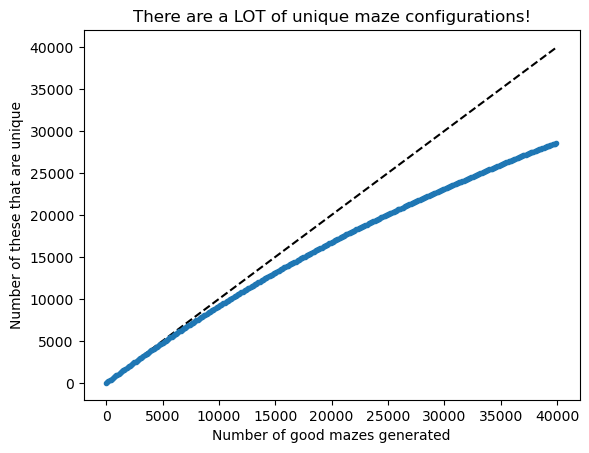

In [46]:
# How many possible configurations are there?
timesteps = list(range(1, 40001, 100))

# Add a unity line for comparison
plt.plot([0, 40000], [0, 40000], 'k--')
# Add how many mazes we actually get
plt.plot(timesteps, number_of_valid_configs, '.')
plt.xlabel("Number of good mazes generated")
plt.ylabel("Number of these that are unique")
plt.title("There are a LOT of unique maze configurations!")
plt.show()


In [47]:
# save it!!!
import pickle

# Save the set to a pickle file
with open('set_of_good_mazes.pkl', 'wb') as file:
    pickle.dump(lots_of_good_mazes, file)
    
# Also save the stats to a pickle file
with open('number_of_valid_configs.pkl', 'wb') as file:
    pickle.dump(number_of_valid_configs, file)  